In [1]:
import requests
import os
from sodapy import Socrata
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import calendar
from matplotlib import interactive
import numpy as np
from shapely.geometry.polygon import Polygon
import seaborn as sns
%matplotlib notebook
%matplotlib inline

In [2]:
socrata_domain = "data.cityofnewyork.us"
s_token= "owhOVQVkxAIoOnckQs4UrHcVo"
client = Socrata(socrata_domain, s_token)
results=client.get("uvbq-3m68",limit=4230000,where="issue_date like'%/2018'")

In [3]:
results_df=pd.DataFrame.from_records(results)

In [4]:
results_df["payment_amount"]=results_df.payment_amount.apply(pd.to_numeric)
results_df["reduction_amount"]=results_df.reduction_amount.apply(pd.to_numeric)
results_df["amount_due"]=results_df.amount_due.apply(pd.to_numeric)
results_df["fine_amount"]=results_df.fine_amount.apply(pd.to_numeric)
results_df["interest_amount"]=results_df.interest_amount.apply(pd.to_numeric)
results_df["penalty_amount"]=results_df.penalty_amount.apply(pd.to_numeric)

In [5]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4230000 entries, 0 to 4229999
Data columns (total 19 columns):
amount_due             float64
county                 object
fine_amount            int64
interest_amount        float64
issue_date             object
issuing_agency         object
judgment_entry_date    object
license_type           object
payment_amount         float64
penalty_amount         int64
plate                  object
precinct               object
reduction_amount       float64
state                  object
summons_image          object
summons_number         object
violation              object
violation_status       object
violation_time         object
dtypes: float64(4), int64(2), object(13)
memory usage: 613.2+ MB


In [6]:
time_list=[]
hours_list=[]
date_list=[]
month_list=[]

#Change Date & Time to DATETIME Object.
violation_time_df = results_df["violation_time"]
for time in violation_time_df:
    try:
        if time[-1:] == "A" or int(time[:2]) == 12:
            try:
                hours_int = int(time[:2])
                minutes_int = int(time[3:5])
                issue_time = datetime.time(hours_int, minutes_int)
            except (ValueError):
                print(time)
        elif time[-1:] == "P" and int(time[:2]) != 12:
            try:
                hours_int = int(time[:2]) + 12
                minutes_int = int(time[3:5])
                issue_time = datetime.time(hours_int, minutes_int)
            except (ValueError):
                print(time)
    except (TypeError):
        hours_int = np.NaN
        minutes_int = np.NaN
        issue_time = np.NaN     
    time_list.append(issue_time)
    hours_list.append(hours_int)
issue_date_df = results_df["issue_date"]
for date in issue_date_df:
    try:
        year_int = int(date[-4:])
        month_int = int(date[:2])
        day_int = int(date[3:5])
        ymd = datetime.datetime(year_int, month_int, day_int)
        date_list.append(ymd)
        month_list.append(month_int)
    except (ValueError):
        year_int = np.NaN
        month_int = np.NaN
        day_int = np.NaN
        ymd = np.NaN
        date_list.append(ymd)
        month_list.append(month_int)    
        

69:58P
15:40P
55:40P
54:24P
55:42P
56:20P
09:.7P
56:15P
16:10P
68:31P
76:51P
68:40P


In [7]:
weekDay=[]
for i in range(0,len(date_list)):
    try:
        weekdayx=calendar.day_name[date_list[i].weekday()]
        weekDay.append(weekdayx)
    except (AttributeError):
        weekDay.append("error in date")

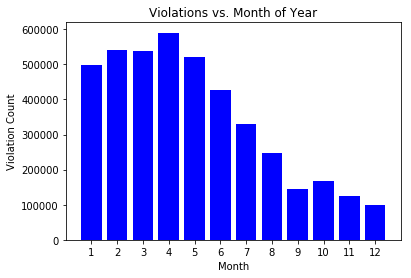

In [8]:
results_df["Date Issued"] = date_list
results_df["Month Issued"] = month_list
results_df["Time Issued"] = time_list
results_df["Hour Issued"] = hours_list

date_grouped_df = results_df.groupby(["Month Issued"])
date_offense_count_df = date_grouped_df.count()

#Create bar chart for violations vs. month of year
plt.bar(date_offense_count_df.index, date_offense_count_df["plate"], color="blue", align="center")
plt.title("Violations vs. Month of Year")
plt.xlabel("Month")
plt.ylabel("Violation Count")
plt.xticks(np.arange(1, 13, 1))
plt.savefig("violation_count_vs_month.png")

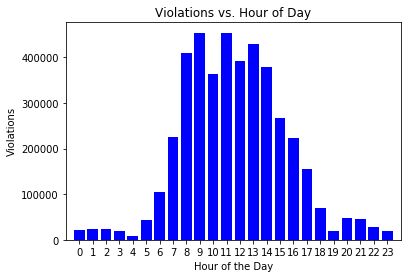

In [9]:

hour_grouped_df = results_df.groupby(["Hour Issued"])
hour_offense_count_df = hour_grouped_df.count()

#Create bar chart for violations vs. time of day
plt.bar(hour_offense_count_df.index, hour_offense_count_df["plate"], color="b", align="center")
plt.xlim(-1, 24)
plt.xticks(np.arange(0, 24, 1))
plt.title("Violations vs. Hour of Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Violations")
plt.savefig("violation_count_vs_hour.png")

In [10]:
violations_grouped=results_df.groupby(["violation"])["summons_number"].count().to_frame()
violations_amount=results_df.groupby(["violation"])["fine_amount"].sum().to_frame()
violations=pd.merge(violations_grouped,violations_amount,on="violation")

total_number_fines=violations_grouped["summons_number"].sum()
total_amount=violations["fine_amount"].sum()

violations["%_Number_Violations"]=violations_grouped["summons_number"]*100/total_number_fines
violations["%_Fine_Amount"]=violations["fine_amount"]*100/total_amount
violations.head(10)

violations.head()

,summons_number,fine_amount,%_Number_Violations,%_Fine_Amount
violation,,,,
ALTERING INTERCITY BUS PERMIT,17,7855,0.000402,0.002523
ANGLE PARKING,2845,131945,0.067262,0.042378
ANGLE PARKING-COMM VEHICLE,88,10065,0.002081,0.003233
BEYOND MARKED SPACE,2266,108820,0.053573,0.034951
BIKE LANE,34930,4016720,0.825819,1.290097


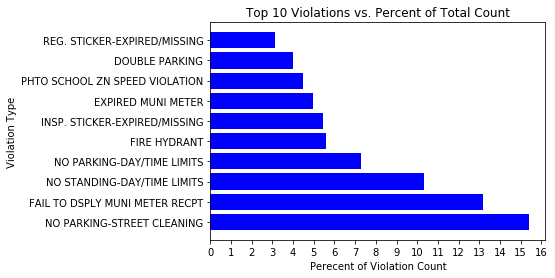

In [11]:
violation_count_sorted = violations.sort_values("summons_number", ascending=False)
violation_count_top_10 = violation_count_sorted.iloc[:10]

plt.barh(violation_count_top_10.index, violation_count_top_10["%_Number_Violations"], color="b", align="center")
plt.title("Top 10 Violations vs. Percent of Total Count")
plt.xlabel("Perecent of Violation Count")
plt.ylabel("Violation Type")
plt.xticks(np.arange(0, 17, 1))
plt.savefig("percent_of_count_vs_type.png")



In [12]:
weekDay=[]
for i in range(0,len(date_list)):
    try:
        weekdayx=calendar.day_name[date_list[i].weekday()]
        weekDay.append(weekdayx)
    except (AttributeError):
        weekDay.append("error in date")

results_df["Weekday"] = weekDay
weekday_grouped=results_df.groupby(["Weekday"])["summons_number"].count()

In [13]:
n_order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday','error in date']


weekday_sorted=weekday_grouped.reindex(n_order,axis=0).to_frame()
weekday_df=weekday_sorted.rename(columns={"summons_number":"#_Tickets"})
total_tickets=weekday_df["#_Tickets"].sum()
weekday_df["%_Tickets/Weekday"]=weekday_df["#_Tickets"]*100/total_tickets
weekday_df


,#_Tickets,%_Tickets/Weekday
Weekday,,
Monday,684127,16.173215
Tuesday,819518,19.373948
Wednesday,657440,15.542317
Thursday,743425,17.575059
Friday,702362,16.604303
Saturday,459318,10.858582
Sunday,163806,3.872482
error in date,4,0.000095


In [14]:
new_order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']


parkingT=results_df[results_df.violation=="NO PARKING-STREET CLEANING"]

parkingT_grouped=parkingT.groupby(["Weekday"])["summons_number"].count()
parkingT_suma=parkingT.groupby(["Weekday"])["fine_amount"].sum()

parkingT_sorted=parkingT_grouped.reindex(new_order,axis=0).to_frame()
parkingT_sum_sorted=parkingT_suma.reindex(new_order,axis=0).to_frame()
total_amount=parkingT_sum_sorted["fine_amount"].sum()
parkingT_sum_sorted["% Fine amount"]=parkingT_sum_sorted["fine_amount"]*100/total_amount

parkingT_sorted=parkingT_sorted.rename(columns={"summons_number":"#Parking-Cleaning Tickets"})
total_ticketsT=parkingT_sorted["#Parking-Cleaning Tickets"].sum()
parkingT_sorted["%_Tickets/Weekday"]=parkingT_sorted["#Parking-Cleaning Tickets"]*100/total_ticketsT


parkingTT=pd.merge(parkingT_sorted,parkingT_sum_sorted,on="Weekday")
parkingTT

npp=parkingTT.style.bar(subset=['%_Tickets/Weekday'], color='#d65f5f',vmin=0.01)
npp

,#Parking-Cleaning Tickets,%_Tickets/Weekday,fine_amount,% Fine amount
Weekday,,,,
Monday,121192,18.5772,5735480,18.6531
Tuesday,168960,25.8994,7971500,25.9251
Wednesday,56075,8.59557,2562835,8.33492
Thursday,132583,20.3233,6255695,20.3449
Friday,136857,20.9784,6483945,21.0873
Saturday,36629,5.61475,1735185,5.64322
Sunday,75,0.0114965,3515,0.0114316


163


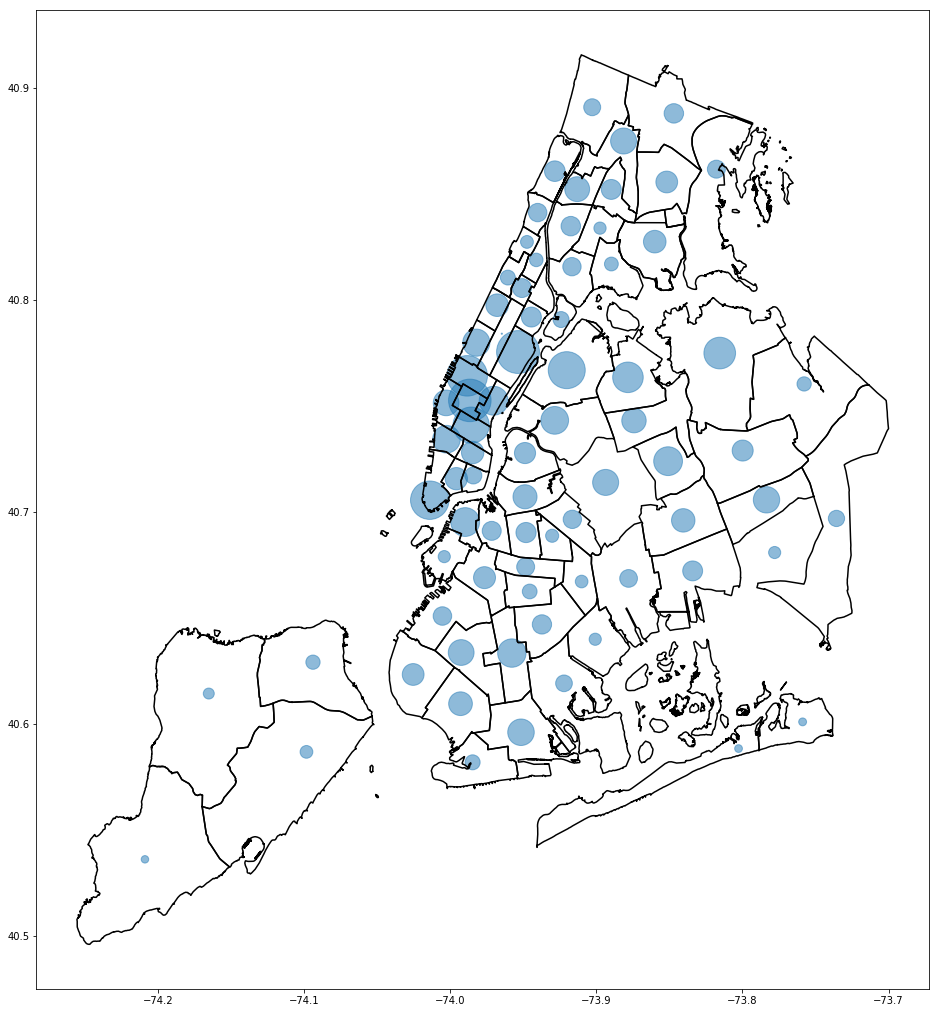

In [15]:
coord=pd.read_excel("Coord_Precinct.xlsx",converters={"Code":str})
coord=coord.rename(columns={"Code":"precinct"})
df_Pr=pd.merge(results_df,coord,on="precinct")
dfCount=df_Pr.groupby(["precinct"])["summons_number"].count()

coord=pd.merge(coord,dfCount,on="precinct")


plt.figure(figsize=(16,18))
for i in range(1,185):
    try:
        ll=pd.read_excel("ll"+str(i)+".xlsx",converters={"lat":str,"lon":str})
        ll["lat"]=ll.lat.apply(pd.to_numeric)
        ll["lon"]=ll.lon.apply(pd.to_numeric)
        valuesx=ll.values.tolist()
    
        poly=Polygon(valuesx)
        x,y=poly.exterior.xy
        plt.plot(x,y,color="k")
    except(FileNotFoundError):
        print(i)

plt.scatter(x=coord["lon"], y=coord["lat"], s=coord["summons_number"]*.01,alpha=0.5)

In [16]:
frequency_plate = results_df[["plate", "amount_due", 
                             "fine_amount", "interest_amount", 
                             "payment_amount", "penalty_amount",
                             "summons_number", "state"]]

frequency_plate_grouping = frequency_plate.groupby(["plate"])
meow = frequency_plate_grouping["summons_number"].count()
woof = frequency_plate_grouping["fine_amount"].sum()

In [17]:
frequency_violation_df = pd.DataFrame({"Total Violation Cost": woof, "Frequency": meow })
frequency_sorted = frequency_violation_df.sort_values("Frequency", ascending=False)
frequency_sorted.head()

,Total Violation Cost,Frequency
plate,,
BLANKPLATE,131283,1666
12125MJ,62120,550
2703427,46920,500
12359MG,56465,495
34914PC,47415,487


In [18]:
total_violation_cost_sorted = frequency_violation_df.sort_values("Total Violation Cost", ascending=False)
total_violation_cost_sorted.head()

,Total Violation Cost,Frequency
plate,,
BLANKPLATE,131283,1666
12125MJ,62120,550
12359MG,56465,495
62423JM,48315,427
83460MH,48215,425


In [19]:
bins = [0,2,250]
groups = ["Up to 2 Tickets", "More than 2 tickets"]

frequency_sorted["breakdown"] = pd.cut(frequency_sorted["Frequency"], bins, labels=groups)
frequency_sorted.head()

,Total Violation Cost,Frequency,breakdown
plate,,,
BLANKPLATE,131283,1666,NaN
12125MJ,62120,550,NaN
2703427,46920,500,NaN
12359MG,56465,495,NaN
34914PC,47415,487,NaN


In [20]:
breakdown_variable = frequency_sorted["breakdown"].value_counts()
breakdown_variable

Up to 2 Tickets        1319671
More than 2 tickets     385007
Name: breakdown, dtype: int64

In [21]:
groupedby_breakdown = frequency_sorted.groupby(["breakdown"])
violation_sum = groupedby_breakdown["Total Violation Cost"].sum()

In [22]:
df_for_graph = pd.DataFrame({"Total $ Generated": violation_sum})
df_for_graph.head()

,Total $ Generated
breakdown,
Up to 2 Tickets,116195351
More than 2 tickets,190212555


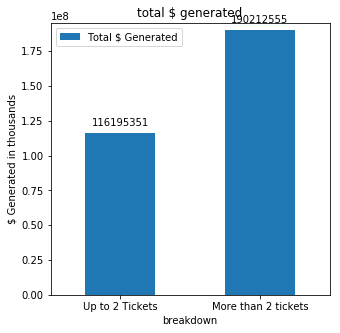

In [23]:
ax = df_for_graph.plot(kind="bar", figsize=(5,5), rot=0)
                  
plt.title("total $ generated")

plt.ylabel("$ Generated in thousands")

for p in ax.patches: 
    ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
plt.ylim(0, max(df_for_graph["Total $ Generated"])+ 5000000)

plt.show()

Text(0, 0.5, '')

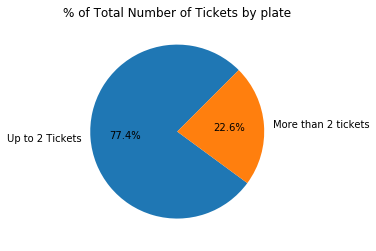

In [24]:
#pie chart

pie = breakdown_variable.plot(kind="pie", title="% of Total Number of Tickets by plate", autopct="%1.1f%%", startangle=45)
pie.set_ylabel("")

Text(0, 0.5, '')

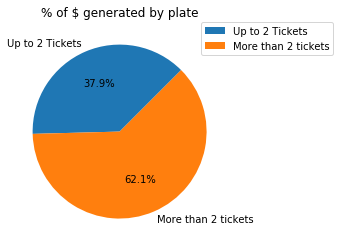

In [25]:
pie2 = violation_sum.plot(kind="pie", title="% of $ generated by plate", autopct="%1.1f%%", startangle=45)
plt.legend(loc="upper left", bbox_to_anchor=(0.85,1.025))
pie2.set_ylabel("")

In [26]:
state_df = results_df[["state", "amount_due", 
                             "fine_amount", "interest_amount", 
                             "payment_amount", "penalty_amount", "summons_number"]]

state_df["Label"] = np.where(state_df["state"]=="NY","NY","Out of State")


state_grouping = state_df.groupby(["Label"])
state_grouping.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,state,amount_due,fine_amount,interest_amount,payment_amount,penalty_amount,summons_number,Label
0,NY,0.0,60,5.42,125.3,60,8589483680,NY
1,NY,75.0,50,0.00,0.0,25,4648772234,NY
2,NY,75.0,50,0.00,0.0,25,4648772404,NY
3,NY,75.0,50,0.00,0.0,25,4648772507,NY
4,NY,0.0,50,0.00,75.0,25,4648772787,NY
13,IN,0.0,65,0.00,65.0,0,8589487635,Out of State
17,NJ,0.0,50,1.79,75.0,25,5102118286,Out of State
21,GA,125.0,115,0.00,0.0,10,8591593790,Out of State
43,PA,55.0,45,0.00,0.0,10,8591595932,Out of State
53,PA,0.0,60,0.00,60.0,0,8552169009,Out of State


In [27]:
fine_amount_sum = state_grouping["fine_amount"].sum()
fine_amount_sum.head()

Label
NY              237396721
Out of State     73970148
Name: fine_amount, dtype: int64

In [28]:
state_frequency = state_grouping["summons_number"].count()
state_frequency.head()

Label
NY              3294617
Out of State     935383
Name: summons_number, dtype: int64

In [29]:
state_combined_df = pd.DataFrame({"Total Violation Cost": fine_amount_sum, "Frequency": state_frequency})

state_fine_sort = state_combined_df.sort_values("Total Violation Cost", ascending=False)
state_fine_sort.head()

,Total Violation Cost,Frequency
Label,,
NY,237396721,3294617
Out of State,73970148,935383


In [30]:
state_frequency_sort = state_combined_df.sort_values("Frequency", ascending=False)
state_frequency_sort.head()

,Total Violation Cost,Frequency
Label,,
NY,237396721,3294617
Out of State,73970148,935383


Text(0, 0.5, '')

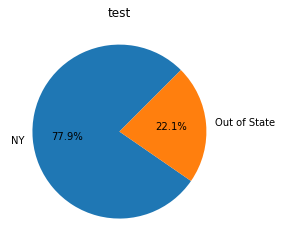

In [31]:
pie3 = state_frequency.plot(kind="pie", title="test", autopct="%1.1f%%", startangle=45)
pie3.set_ylabel("")

Text(0, 0.5, '')

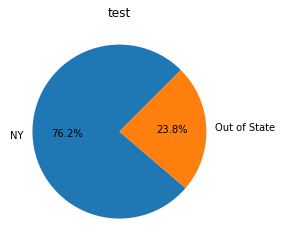

In [32]:
pie4 = fine_amount_sum.plot(kind="pie", title="test", autopct="%1.1f%%", startangle=45)
pie4.set_ylabel("")

In [33]:
#Filter the dataset so that the ones without violation status are dropped

results_df2= results_df.dropna(subset=['violation_status'])
results_df2
#Finding all types of violation types
results_df2["violation_status"].unique()

array(['HEARING HELD-GUILTY', 'HEARING HELD-NOT GUILTY',
       'HEARING ADJOURNMENT', 'HEARING HELD-GUILTY REDUCTION',
       'ADMIN CLAIM GRANTED', 'APPEAL ABANDONED', 'ADMIN REDUCTION',
       'ADMIN CLAIM DENIED', 'APPEAL AFFIRMED', 'HEARING PENDING',
       'APPEAL REVERSED', 'APPEAL MODIFIED', 'HEARING HELD-REINSTATEMENT'],
      dtype=object)

In [34]:
#Drop and filter the dataset even further because we're only concerend with the initial decision of the court
results3=results_df2[results_df2.violation_status != ("HEARING ADJOURNMENT", "HEARING PENDING", "ADMIN CLAIM DENIED",
                                                      "APPEAL AFFIRMED", "ADMIN REDUCTION", "APPEAL REVERSED",
                                                      "ADMIN CLAIM GRANTED", "APPEAL ABANDONED", "HEARING HELD-REINSTATEMENT",
                                                      "APPEAL REMANDED", "APPEAL MODIFIED", "HEARING WAIVED")]
results3

,amount_due,county,fine_amount,interest_amount,issue_date,issuing_agency,judgment_entry_date,license_type,payment_amount,penalty_amount,...,summons_image,summons_number,violation,violation_status,violation_time,Date Issued,Month Issued,Time Issued,Hour Issued,Weekday
13,0.0,NY,65,0.00,05/08/2018,TRAFFIC,NaN,PAS,65.00,0,...,{'url': 'http://nycserv.nyc.gov/NYCServWeb/Sho...,8589487635,PLTFRM LFTS LWRD POS COMM VEH,HEARING HELD-GUILTY,11:32A,2018-05-08,5.0,11:32:00,11.0,Tuesday
24,0.0,Q,45,0.00,01/03/2018,TRAFFIC,NaN,PAS,45.00,0,...,{'url': 'http://nycserv.nyc.gov/NYCServWeb/Sho...,8552168571,NO PARKING-STREET CLEANING,HEARING HELD-GUILTY,08:46A,2018-01-03,1.0,08:46:00,8.0,Wednesday
38,0.0,K,115,0.00,02/12/2018,TRAFFIC,NaN,PAS,115.00,0,...,{'url': 'http://nycserv.nyc.gov/NYCServWeb/Sho...,8547289940,FIRE HYDRANT,HEARING HELD-GUILTY,05:44P,2018-02-12,2.0,17:44:00,17.0,Monday
57,0.0,Q,60,0.00,01/08/2018,TRAFFIC,NaN,PAS,0.00,0,...,{'url': 'http://nycserv.nyc.gov/NYCServWeb/Sho...,8552168972,NO PARKING-DAY/TIME LIMITS,HEARING HELD-NOT GUILTY,07:26A,2018-01-08,1.0,07:26:00,7.0,Monday
90,0.0,Q,115,0.00,01/11/2018,TRAFFIC,NaN,PAS,0.00,0,...,{'url': 'http://nycserv.nyc.gov/NYCServWeb/Sho...,8552169721,NO STOPPING-DAY/TIME LIMITS,HEARING HELD-NOT GUILTY,06:08A,2018-01-11,1.0,06:08:00,6.0,Thursday
94,75.0,BK,50,0.00,10/15/2018,DEPARTMENT OF TRANSPORTATION,NaN,PAS,0.00,25,...,{'url': 'http://nycserv.nyc.gov/NYCServWeb/Sho...,4648779095,PHTO SCHOOL ZN SPEED VIOLATION,HEARING ADJOURNMENT,01:09P,2018-10-15,10.0,13:09:00,13.0,Monday
116,25.0,BX,50,0.00,10/15/2018,DEPARTMENT OF TRANSPORTATION,NaN,COM,50.00,25,...,{'url': 'http://nycserv.nyc.gov/NYCServWeb/Sho...,4648781181,PHTO SCHOOL ZN SPEED VIOLATION,HEARING HELD-GUILTY,01:41P,2018-10-15,10.0,13:41:00,13.0,Monday
125,0.0,NY,115,0.00,04/26/2018,TRAFFIC,NaN,PAS,115.00,0,...,{'url': 'http://nycserv.nyc.gov/NYCServWeb/Sho...,8514329376,DOUBLE PARKING,HEARING HELD-GUILTY,12:15P,2018-04-26,4.0,12:15:00,12.0,Thursday
142,0.0,BX,65,0.00,01/04/2018,TRAFFIC,NaN,PAS,75.00,10,...,{'url': 'http://nycserv.nyc.gov/NYCServWeb/Sho...,8531098210,FRONT OR BACK PLATE MISSING,HEARING HELD-GUILTY,07:05A,2018-01-04,1.0,07:05:00,7.0,Thursday
155,0.0,BK,50,1.61,06/20/2018,DEPARTMENT OF TRANSPORTATION,11/08/2018,PAS,76.48,25,...,{'url': 'http://nycserv.nyc.gov/NYCServWeb/Sho...,5102142537,FAILURE TO STOP AT RED LIGHT,HEARING HELD-GUILTY,05:34P,2018-06-20,6.0,17:34:00,17.0,Wednesday


In [35]:
#NY Drivers
ny_drivers=results3[results3["state"]=="NY"]
#Out of State Drivers
out_of_state_drivers=results3[results3["state"]!="NY"]
#Guilty NY drivers
guilty=results3[(results3["violation_status"]=="HEARING HELD-GUILTY") & (results3["state"]=="NY")]

#Not guilty NY drivers
not_guilty=results3[(results3["violation_status"]=="HEARING HELD-NOT GUILTY") & (results3["state"]=="NY")] 

#Finding the total number of guilty and not guilty for NY drivers
guilty_count= len(guilty.index)
not_guilty_count= len(not_guilty.index)

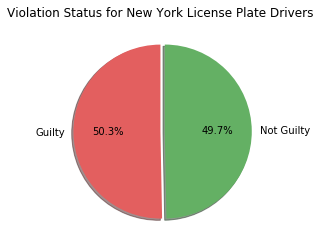

In [36]:
#Pie chart for NY drivers who had a hearing
labels=["Guilty","Not Guilty"]
ny_sizes=[guilty_count,not_guilty_count]
colors=["#e35f5f","#64b064"]
explode = (0, 0.05)

plt.pie(ny_sizes, shadow=True, startangle=90, explode=explode, labels=labels, colors=colors, autopct='%.1f%%')
plt.title("Violation Status for New York License Plate Drivers")

plt.savefig("New York License Plate Drivers Violation Status")
#Out-of-State drivers
oos_guilty=results3[(results3["violation_status"]=="HEARING HELD-GUILTY") & (results3["state"]!="NY")]

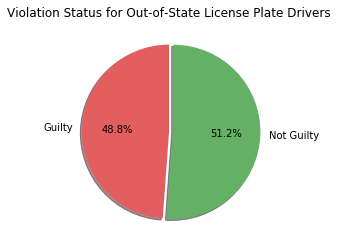

In [37]:
#Out-of-State drivers
oos_not_guilty=results3[(results3["violation_status"]=="HEARING HELD-NOT GUILTY") & (results3["state"]!="NY")]

#Finding the total number of guilty and not guilty for Out-of-State drivers
oos_guilty_count= len(oos_guilty.index)
oos_not_guilty_count= len(oos_not_guilty.index)
#Pie chart for Out-of-State drivers who had a hearing
oos_labels=["Guilty","Not Guilty"]
oos_sizes=[oos_guilty_count,oos_not_guilty_count]
colors=["#e35f5f","#64b064"]
explode = (0, 0.05)

plt.pie(oos_sizes, shadow=True, startangle=90, explode=explode, labels=oos_labels, colors=colors, autopct='%.1f%%')
plt.title("Violation Status for Out-of-State License Plate Drivers")

plt.savefig("Out-of-State License Plate Drivers Violation Status")

In [38]:
#NY drivers who were guilty but had their fine reduced 
guilty_reduction=results3[(results3["violation_status"]=="HEARING HELD-GUILTY REDUCTION") & (results3["state"]=="NY")]
#Out-of-State drivers who were guilty but had their fine reduced
oos_guilty_reduction=results3[(results3["violation_status"]=="HEARING HELD-GUILTY REDUCTION") & (results3["state"]!="NY")]
#Finding the total number of drivers who had their fines reduced
ny_fine_reduced_count= len(guilty_reduction.index)
oos_fine_reduced_count= len(oos_guilty_reduction.index)
#Percentage of guilty NY drivers who got their fine reduced
percentage_of_fine_reduced_ny_drivers=ny_fine_reduced_count/(guilty_count+ny_fine_reduced_count)
percentage_of_fine_reduced_ny_drivers

0.5150594655100041

In [39]:
#Percentage of guilty Out-of-State drivers who got their fine reduced
percentage_of_fine_reduced_oos_drivers=oos_fine_reduced_count/(oos_guilty_count+oos_fine_reduced_count)
percentage_of_fine_reduced_oos_drivers

0.2720972629698045

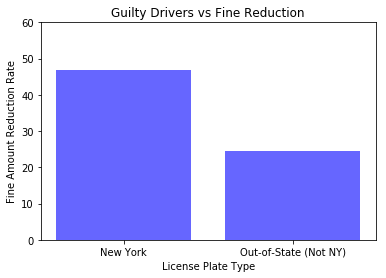

In [40]:
#Bar graph showing the percentage of drivers who got their fine reduced respective to their license plate state
users = [46.94,24.40]
x_axis = np.arange(len(users))

tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, ["New York", "Out-of-State (Not NY)"])

plt.bar(x_axis, users, color="blue", alpha= .6, align="center")
plt.title("Guilty Drivers vs Fine Reduction")
plt.xlabel("License Plate Type")
plt.ylabel("Fine Amount Reduction Rate")
plt.ylim(0,60)

plt.savefig("Fine Reduction Rate per State License Type")